In [1]:
import os
import numpy as np
from collections import defaultdict, Counter
from torch.utils.data import Sampler
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import time
import copy
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.auto import tqdm
from collections import defaultdict
from torchsummary import summary
import matplotlib.pyplot as plt
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
val_dataset = datasets.ImageFolder(root='/kaggle/input/cnw-patches/augmented_version/kaggle/working/dataset_val', transform=transform)

In [4]:

val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [5]:
import os
import cv2
import torch.nn.functional as F

In [6]:
class PatchEmbed(nn.Module):
    """Split image into patches and embed them."""
    
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        x = self.proj(x)  # Shape: [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)  # Shape: [B, embed_dim, n_patches]
        x = x.transpose(1, 2)  # Shape: [B, n_patches, embed_dim]
        return x

In [7]:
class Attention(nn.Module):
    """Multi-head Attention mechanism."""
    
    def __init__(self, dim, num_heads=3, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x):
        B, N, C = x.shape  # [batch_size, n_patches + 1, embed_dim]
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each with shape [B, num_heads, N, head_dim]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B, num_heads, N, N]
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [8]:
class MLP(nn.Module):
    """MLP block."""
    
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [9]:
class Block(nn.Module):
    """Transformer encoder block."""
    
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), out_features=dim, drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [10]:
class ViTTiny(nn.Module):
    """Vision Transformer for 32x32 images."""
    
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=192, 
                 depth=12, num_heads=3, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, 
                  drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)
        ])
        
        # Final normalization and classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        # Initialize position embeddings and cls token
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, n_patches, embed_dim]
        
        # Prepend class token
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_token, x), dim=1)  # [B, 1 + n_patches, embed_dim]
        
        # Add position embedding
        x = x + self.pos_embed  # [B, 1 + n_patches, embed_dim]
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        return x[:, 0]  # Return only the class token
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [11]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device=None, class_names=None):
    """
    Evaluate the model and display metrics.

    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        device: 'cuda' or 'cpu'
        class_names: List of 17 class names
    
    Returns:
        accuracy: Overall test accuracy
        confusion_mat: Confusion matrix
        report_dict: Classification report as a dict
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Evaluating")
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n✅ Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    confusion_mat = confusion_matrix(all_labels, all_preds, labels=list(range(17)))
    cm_df = pd.DataFrame(confusion_mat,
                         index=class_names if class_names else [f"Class {i}" for i in range(17)],
                         columns=class_names if class_names else [f"Class {i}" for i in range(17)])

    print("\n🧩 Confusion Matrix:")
    display(cm_df)  # for Jupyter-like environments
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification Report
    report_dict = classification_report(
        all_labels,
        all_preds,
        labels=list(range(17)),
        target_names=class_names if class_names else [f"Class {i}" for i in range(17)],
        output_dict=True,
        zero_division=0
    )

    report_df = pd.DataFrame(report_dict).transpose()
    print("\n📊 Classification Report:")
    display(report_df.round(3))

    return accuracy, confusion_mat, report_dict


In [12]:
model = ViTTiny(
    img_size=32,            # Input image size
    patch_size=4,           # Patch size
    in_chans=3,             # Input channels (RGB)
    num_classes=17,         # Number of classes
    embed_dim=128,          # Embedding dimension
    depth=6,               # Number of transformer blocks
    num_heads=2,            # Number of attention heads
    mlp_ratio=4.,           # MLP expansion ratio
    qkv_bias=True,          # Use bias for QKV projection
    drop_rate=0.2,          # Dropout rate
    attn_drop_rate=0.2       # Attention dropout rate
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model.load_state_dict(torch.load("/kaggle/input/vit-train-patches/vit_tiny_32x32.pth", map_location='cpu'))

/tmp/ipykernel_31/3405265169.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/vit-train-patches/vit_tiny_32x32.pth", map_l

<All keys matched successfully>

In [15]:
class_names = ["Crop", "Grasses", "Amarnath","Goosefoot", "Knotweed", "Corn Spurry", "Chickweed", "Solanales", "Potato Weed", "Chamomile", "Thistle", "Mercuries", "Geranium", "Crucifer", "Poppy", "Plantago", "Labiate"]

Evaluating: 100%|██████████| 56/56 [00:43<00:00,  1.30it/s]


✅ Test Accuracy: 0.7852

🧩 Confusion Matrix:


,Crop,Grasses,Amarnath,Goosefoot,Knotweed,Corn Spurry,Chickweed,Solanales,Potato Weed,Chamomile,Thistle,Mercuries,Geranium,Crucifer,Poppy,Plantago,Labiate
Crop,3097,85,144,18,23,6,1,10,5,23,40,37,0,2,14,31,5
Grasses,88,3167,160,37,62,20,5,61,5,24,63,35,54,1,18,20,36
Amarnath,93,54,1183,12,63,25,3,6,4,39,34,25,1,0,7,19,3
Goosefoot,9,5,9,151,2,1,1,0,3,3,1,3,1,0,0,9,1
Knotweed,17,30,34,7,788,18,2,6,2,15,5,18,1,2,0,17,5
Corn Spurry,11,10,21,1,20,227,3,4,3,7,5,6,0,0,0,8,3
Chickweed,8,6,7,2,4,9,109,2,0,1,0,1,0,2,0,9,1
Solanales,11,57,12,4,5,11,3,107,0,3,3,2,2,0,0,8,1
Potato Weed,2,2,2,0,1,0,0,0,102,1,2,2,0,0,1,3,0
Chamomile,21,11,41,2,16,15,0,3,0,485,21,13,5,0,8,7,8


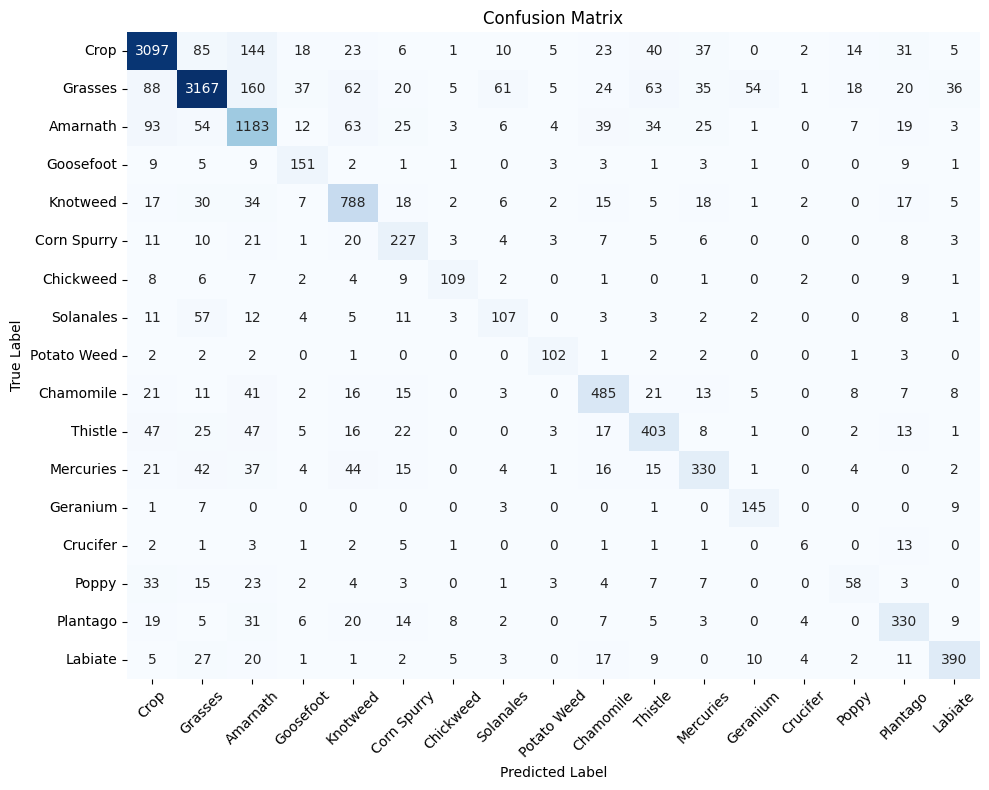


📊 Classification Report:


,precision,recall,f1-score,support
Crop,0.889,0.875,0.882,3541.000
Grasses,0.892,0.821,0.855,3856.000
Amarnath,0.667,0.753,0.707,1571.000
Goosefoot,0.597,0.759,0.668,199.000
Knotweed,0.736,0.815,0.773,967.000
Corn Spurry,0.578,0.690,0.629,329.000
Chickweed,0.773,0.677,0.722,161.000
Solanales,0.505,0.467,0.485,229.000
Potato Weed,0.779,0.864,0.819,118.000
Chamomile,0.732,0.739,0.735,656.000


Final test accuracy: 0.7852


In [17]:
# Save the trained model
# torch.save(trained_model.state_dict(), 'vit_tiny_32x32.pth')
# plot_training_history(training_history)

# Evaluate on test set
test_accuracy, _,_ = evaluate_model(model, val_loader, device, class_names = class_names)

print(f"Final test accuracy: {test_accuracy:.4f}")